# Pairs Trading Fundamentals

Welcome to this exploration of pairs trading, a market-neutral trading strategy that aims to capitalize on the relationship between two financially linked securities.

## Defining Pairs Trading

Pairs trading involves simultaneously buying and selling two related securities when their prices diverge in a way that's historically unusual. Traders expect that the prices will eventually converge, generating profit from the narrowing of the gap. This strategy is considered market-neutral because it doesn't rely on the overall market's direction but rather on the relationship between the two securities.

## Prerequisites in Python

To analyze and implement pairs trading strategies, we'll utilize several Python libraries:

- **`pandas`:** Essential for data manipulation and analysis, offering data structures and operations for manipulating numerical tables and time series.
- **`numpy`:** Provides support for complex mathematical operations and large, multi-dimensional arrays and matrices.
- **`matplotlib`:** Useful for plotting graphs, which can help in visualizing the price relationship and spread between pairs.
- **`scipy`:** Builds on top of NumPy, offering a wide range of advanced scientific computing functionalities critical for financial analysis.
- **`statsmodels`:** Essential for conducting statistical tests. This includes tools for conducting the Dickey-Fuller test, which we'll explore as a method for determining stationarity in time series data.

These tools will be crucial in our analysis

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller

# To effectively understand pairs trading, it's essential to first grasp a few foundational concepts.

## Concept 1: Stationarity

A stationary time series has properties that do not depend on the time at which the series is observed. Characteristics of a stationary time series include:

1. **Consistent Mean μ:** The series showcases a stable average value over its duration, without trend-induced drifts.
2. **Uniform Variance σ:** Fluctuations around the series mean are consistent, indicating unchanging volatility.
3. **Absence of Seasonality:** The data does not contain periodic patterns or cycles.

## Concept 2: Cointegration

Cointegration is a statistical property indicating a long-term equilibrium relationship between two or more time series. Despite individual series being non-stationary, their combination can be stationary. In simple terms, if two or more series are cointegrated, they move together over time and have a stable, long-term relationship. This concept is crucial in pairs trading, as it helps identify pairs of assets whose prices are linked together in the long run.

# Simulating Stock Prices for Pairs Trading

Now, we will simulate two fake stock prices. The first stock price will be simulated using the Brownian motion differential equation, and then we'll discretize it using the Euler-Maruyama discretization method. 

**Brownian motion differential equation:**

\begin{equation}
\frac{dS_t}{dt} = \mu S_t + \sigma S_t dW_t
\end{equation}

**Discretized equation using the Euler-Maruyama discretization method:**

\begin{equation}
S_t = S_{t-1} + \mu S_{t-1} \Delta t + \sigma S_{t-1} \sqrt{(\Delta t)} W
\end{equation}


However, you don't need to understand any of this right now. All you need to know is that it's a method of simulating a stock price with specific Mu (expected return) and Sigma (volatility) conditions. 

The second stock price will be the mirror of the first one, except we will add a small disturbance to ensure they follow each other, just not perfectly.


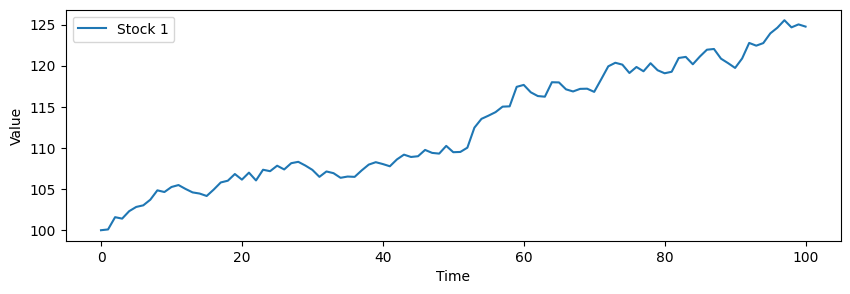

In [171]:
""" User Inputs"""

mu = 0.1
sigma = 0.1
TimeStep = 1/252
Number_Of_TimeSteps=100

""" Simulating Stock 1 """

def BrownianMotion(Mu,Sigma,TimeStep,Price): #Function that implements the discretized equation above
    return Price+(Price*Mu*TimeStep)+(Price*np.sqrt(TimeStep)*Sigma*norm.ppf(np.random.rand()))

Stock_1 = pd.DataFrame([None] for i in range(0,Number_Of_TimeSteps+1)) #Creating empty dataframe
Stock_1.iloc[0,0] = 100  #Keeping an initial stock price, here being 100

for i in range(1,Number_Of_TimeSteps+1): #Populating the rest of teh cells with simulation data
    Stock_1.iloc[i,0] = BrownianMotion(mu,sigma,TimeStep,Stock_1.iloc[i-1,0])

""" Plotting a Graph for Stock 1 """

plt.figure(figsize=(10, 3)) #You can change the size of the plot output here
plt.plot(Stock_1)
plt.legend(['Stock 1'])
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

We add a disturbance to stock 1 to create stock price 2. This approach is taken because both stocks are supposed to be economically linked.

Following the `Law of One Price`, we assume that they either have the same price or at least move alongside each other. 

This disturbance ensures that while Stock 2 closely mirrors Stock 1, it's not an exact replica, thereby simulating real-world scenarios where two economically linked assets exhibit similar but not identical price movements.


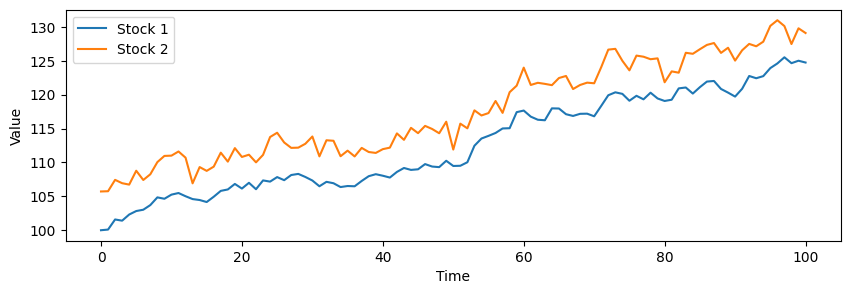

In [172]:
""" Creating Stock 2 """

Stock_2 = pd.DataFrame([None] for i in range(0,Number_Of_TimeSteps+1)) #Creating empty dataframe

for i in range(0,Number_Of_TimeSteps+1): #Iterating through stock 1 and adding disturbance of +5 and random value to create stock
    Stock_2.iloc[i,0] = Stock_1.iloc[i,0] + 5 + np.random.normal(0)

""" Plotting a Graph for Stock 1 & 2 """

plt.figure(figsize=(10, 3)) #You can change the size of the plot output here
plt.plot(Stock_1)
plt.plot(Stock_2)
plt.legend(['Stock 1','Stock 2'])
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

Now that we have two similar stock prices, you might wonder how we can transform these two separate non-stationary time series into a stationary one. 

The answer lies in the log difference. By calculating the log of the ratio between Stock 1 and Stock 2 `log(Stock 1 / Stock 2)`, we create a completely new time series. This time series will represent the size of the gap between the two stock prices, making it easier to identify and exploit patterns within their movements.

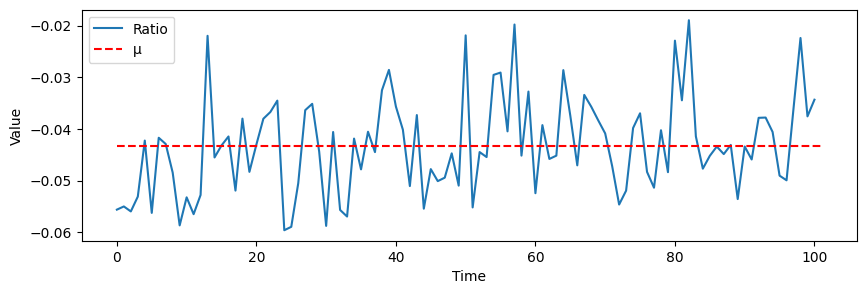

In [173]:
""" Calculating Ratio """

Ratio = pd.DataFrame([None] for i in range(0,Number_Of_TimeSteps+1)) #Creating empty dataframe

for i in range(0,Number_Of_TimeSteps+1): #Iterating through stock 1 and adding disturbance of +5 and random value to create stock
    Ratio.iloc[i,0] = np.log(Stock_1.iloc[i,0] / Stock_2.iloc[i,0])

""" Plotting a Graph for Ratio """

plt.figure(figsize=(10, 3)) #You can change the size of the plot output here
plt.plot(Ratio)
plt.hlines(np.mean(Ratio),0,len(Ratio),colors="r",linestyles="dashed")
plt.legend(['Ratio','μ'])
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [174]:
""" ADF Test Function """

def ADF_Test(TimeSeries, Level_of_significance=0.01): #Takes 2 inputs: the series to test, and level of significance with default value of 0.01
    Pvalue = adfuller(TimeSeries)[1]
    print("P Value : ",Pvalue)
    print("Level Of Significance : ",Level_of_significance)
    if Pvalue <= Level_of_significance:
        #There is enough evidence to not reject the Null Hypothesis
        print("The Time Series is likely Stationary")
    elif Pvalue > Level_of_significance:
        #There is not enough evidence to reject the Null Hypothesis
        print("The Time Series is likely Non-stationary")

print("Ratio - ADF Test Result" +"\n")
ADF_Test(Ratio)

Ratio - ADF Test Result

P Value :  3.3313452272693383e-06
Level Of Significance :  0.01
The Time Series is likely Stationary


After applying the Augmented Dickey-Fuller test to the log difference (the ratio) between `Stock 1` and `Stock 2`, the result confirms that the series is indeed stationary. This finding demonstrates that it is possible to take two non-stationary time series, `Stock 1` and `Stock 2`, and combine them in such a way to create a stationary time series.

The question then arises: How can someone use the log difference to identify trading signals and execute trades based on the graph?

Simplifying how to use the log difference for trading signals involves understanding a couple of key points:

- **Mean Reversion in Stationary Data:** Because the data (log difference) is stationary, it's expected to revert to its mean over time. Therefore, when the stock price ratio deviates significantly from the mean, a trading opportunity may arise.

   - If the ratio is **above the mean**, it indicates that the numerator (Stock 1) is overvalued relative to the denominator (Stock 2). In this scenario, you would **short Stock 1** and **long Stock 2**.

   - Conversely, if the ratio is **below the mean**, it suggests that the numerator (Stock 1) is undervalued compared to the denominator (Stock 2). Here, you should **short Stock 2** and **long Stock 1**.
   
These guidelines provide a simplified method for identifying and acting on trading signals derived from the stationary time series of the log difference between two stock prices.

Adding to this understanding, it's important to note that this is a foundational concept, but real-world data often presents inconsistencies and inefficiencies, making the application of these trades slightly more complicated. Navigating these challenges requires a nuanced understanding of the market and potentially more sophisticated analytical tools.